<a href="https://colab.research.google.com/github/AntaraP741/MicroDoppler-Based-Classification/blob/main/codeMicrodopplerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.utils.data as Data
from torch import Tensor
from torch.autograd import Variable
import numpy as np


In [ ]:
import zipfile
import os

folder_path = "/content"

# loop through all .zip files in folder
for file in os.listdir(folder_path):
    if file.endswith(".zip"):
        zip_path = os.path.join(folder_path, file)
        extract_path = os.path.join(folder_path, file.replace(".zip", ""))  # extract into folder with same name
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Extracted: {file} → {extract_path}")


✅ Extracted: 3_short_blade_rotor_1.zip → /content/3_short_blade_rotor_1
✅ Extracted: 3_long_blade_rotor.zip → /content/3_long_blade_rotor
✅ Extracted: drone_1.zip → /content/drone_1
✅ Extracted: Bird.zip → /content/Bird
✅ Extracted: RC plane_1.zip → /content/RC plane_1


In [ ]:
import os

base_path = "/content"

img_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

for root, dirs, files in os.walk(base_path):

    img_count = sum(1 for f in files if f.lower().endswith(img_exts))
    if img_count > 0:
        print(f"{root}: {img_count} images")


/content/drone_1/drone_1: 400 images
/content/3_short_blade_rotor_1/3_short_blade_rotor_1: 400 images
/content/RC plane_1/2_blade_rotor_1: 400 images
/content/3_long_blade_rotor/3_long_blades_rotor: 799 images
/content/Bird/Bird: 800 images
/content/DIAT_dataset/Bird: 800 images
/content/DIAT_dataset/Short_Blade_Rotor: 400 images
/content/DIAT_dataset/Drone: 400 images
/content/DIAT_dataset/Long_Blade_Rotor: 799 images
/content/DIAT_dataset/RC_Plane: 400 images


In [ ]:
import os, shutil

# create a clean dataset folder
base_dir = "/content/DIAT_dataset"
os.makedirs(base_dir, exist_ok=True)

# map your folders into class names
class_folders = {
    "Bird": "/content/Bird/Bird",
    "Drone": "/content/drone_1/drone_1",
    "Long_Blade_Rotor": "/content/3_long_blade_rotor/3_long_blades_rotor",
    "Short_Blade_Rotor": "/content/3_short_blade_rotor_1/3_short_blade_rotor_1",
    "RC_Plane": "/content/RC plane_1/2_blade_rotor_1"
}

# copy images into unified structure
for class_name, src_path in class_folders.items():
    dst_path = os.path.join(base_dir, class_name)
    os.makedirs(dst_path, exist_ok=True)
    for file in os.listdir(src_path):
        if file.lower().endswith(('.jpg','.png','.jpeg')):
            shutil.copy(os.path.join(src_path, file), dst_path)

print("✅ Dataset consolidated into:", base_dir)


✅ Dataset consolidated into: /content/DIAT_dataset


In [ ]:
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Step 3: Load with ImageFolder
dataset = datasets.ImageFolder(root=base_dir, transform=augment)

print("Classes found:", dataset.classes)
print("Total images:", len(dataset))


Classes found: ['Bird', 'Drone', 'Long_Blade_Rotor', 'RC_Plane', 'Short_Blade_Rotor']
Total images: 2799


In [ ]:
import os, random, shutil
from PIL import Image
from torchvision import transforms

# target range
MIN_IMAGES = 400
MAX_IMAGES = 450
TARGET = random.randint(MIN_IMAGES, MAX_IMAGES)

# augment pipeline
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
])

dataset_root = "/content/DIAT_dataset"  # after consolidation

def balance_class(class_folder, target=TARGET):
    files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    n = len(files)

    # 🔹 Case 1: Too many images → downsample
    if n > target:
        keep = random.sample(files, target)
        for f in files:
            if f not in keep:
                os.remove(os.path.join(class_folder, f))
        print(f"🔻 {class_folder}: reduced from {n} → {target}")

    # 🔹 Case 2: Too few images → augment
    elif n < target:
        i = 0
        while len(files) < target:
            img_path = os.path.join(class_folder, random.choice(files))
            img = Image.open(img_path).convert("RGB")
            new_img = augment(img)
            new_name = f"aug_{i}.jpg"
            new_path = os.path.join(class_folder, new_name)
            new_img.save(new_path)
            files.append(new_name)
            i += 1
        print(f"🔺 {class_folder}: increased from {n} → {len(files)}")

    else:
        print(f" {class_folder}: already {n} images")

# run for each class
for cls in os.listdir(dataset_root):
    class_folder = os.path.join(dataset_root, cls)
    if os.path.isdir(class_folder):
        balance_class(class_folder, target=TARGET)


🔻 /content/DIAT_dataset/Bird: reduced from 800 → 404
🔺 /content/DIAT_dataset/Short_Blade_Rotor: increased from 400 → 404
🔺 /content/DIAT_dataset/Drone: increased from 400 → 404
🔻 /content/DIAT_dataset/Long_Blade_Rotor: reduced from 799 → 404
🔺 /content/DIAT_dataset/RC_Plane: increased from 400 → 404


In [ ]:
from torch.utils.data import random_split, DataLoader

dataset = datasets.ImageFolder(root="/content/DIAT_dataset", transform=augment)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# apply different transform for validation
val_dataset.dataset.transform = basic_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("✅ Train samples:", len(train_dataset))
print("✅ Validation samples:", len(val_dataset))


✅ Train samples: 1616
✅ Validation samples: 404


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")  # pretrained
for param in model.parameters():
    param.requires_grad = False  # freeze all layers

# replace final FC layer (ImageNet had 1000 outputs → now 5 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 UAV classes
model = model.to(device)

# -------------------------------
# 4. Loss & Optimizer
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


KeyboardInterrupt: 

In [ ]:

epochs = 10
for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, running_corrects = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.double() / len(train_dataset)
    # --- Validation ---
    model.eval()
    val_loss, val_corrects = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 0.8399, Acc: 0.7252 | Val Loss: 0.4838, Acc: 0.8861
Epoch 2/10 | Train Loss: 0.4277, Acc: 0.8818 | Val Loss: 0.3298, Acc: 0.9059
Epoch 3/10 | Train Loss: 0.3286, Acc: 0.9090 | Val Loss: 0.2702, Acc: 0.9381
Epoch 4/10 | Train Loss: 0.2824, Acc: 0.9115 | Val Loss: 0.2352, Acc: 0.9381
Epoch 5/10 | Train Loss: 0.2669, Acc: 0.9103 | Val Loss: 0.2134, Acc: 0.9307
Epoch 6/10 | Train Loss: 0.2350, Acc: 0.9295 | Val Loss: 0.2041, Acc: 0.9381
Epoch 7/10 | Train Loss: 0.2095, Acc: 0.9313 | Val Loss: 0.2221, Acc: 0.9208
Epoch 8/10 | Train Loss: 0.2038, Acc: 0.9387 | Val Loss: 0.1857, Acc: 0.9356
Epoch 9/10 | Train Loss: 0.1738, Acc: 0.9530 | Val Loss: 0.1705, Acc: 0.9455
Epoch 10/10 | Train Loss: 0.1700, Acc: 0.9486 | Val Loss: 0.1782, Acc: 0.9307


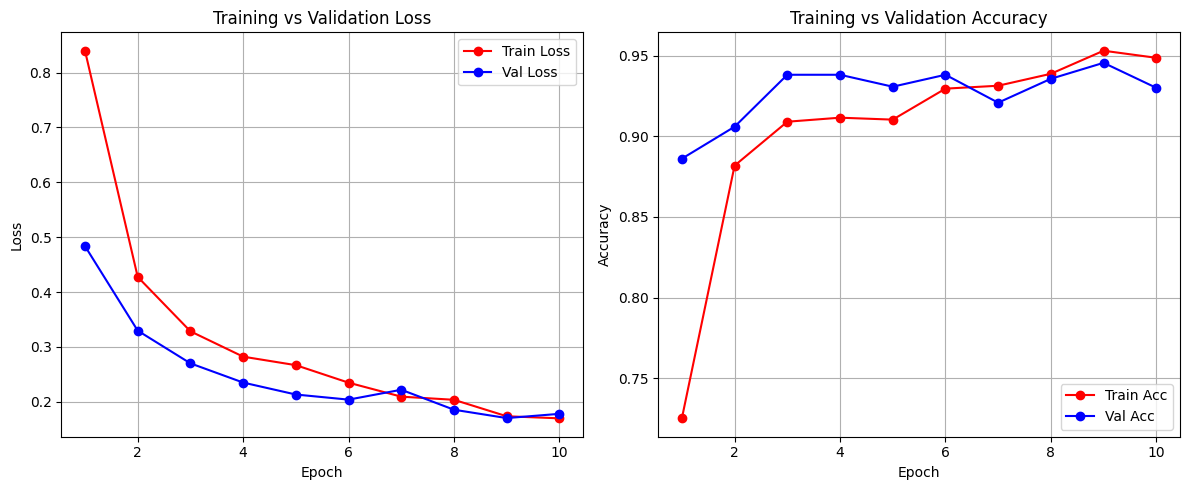

In [ ]:
import matplotlib.pyplot as plt

# Data from your training log
epochs = list(range(1, 11))
train_loss = [0.8399, 0.4277, 0.3286, 0.2824, 0.2669, 0.2350, 0.2095, 0.2038, 0.1738, 0.1700]
val_loss   = [0.4838, 0.3298, 0.2702, 0.2352, 0.2134, 0.2041, 0.2221, 0.1857, 0.1705, 0.1782]

train_acc  = [0.7252, 0.8818, 0.9090, 0.9115, 0.9103, 0.9295, 0.9313, 0.9387, 0.9530, 0.9486]
val_acc    = [0.8861, 0.9059, 0.9381, 0.9381, 0.9307, 0.9381, 0.9208, 0.9356, 0.9455, 0.9300]

# Create a figure with 2 subplots
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-r', label='Train Loss')
plt.plot(epochs, val_loss, 'o-b', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-r', label='Train Acc')
plt.plot(epochs, val_acc, 'o-b', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
  train_loss = running_loss / len(train_dataset)
  train_acc = running_corrects.double() / len(train_dataset)

In [ ]:
print("Train Loss history:", len(train_losses))
print("Val Loss history:", len(val_losses))
print("Train Acc history:", len(train_accs))
print("Val Acc history:", len(val_accs))


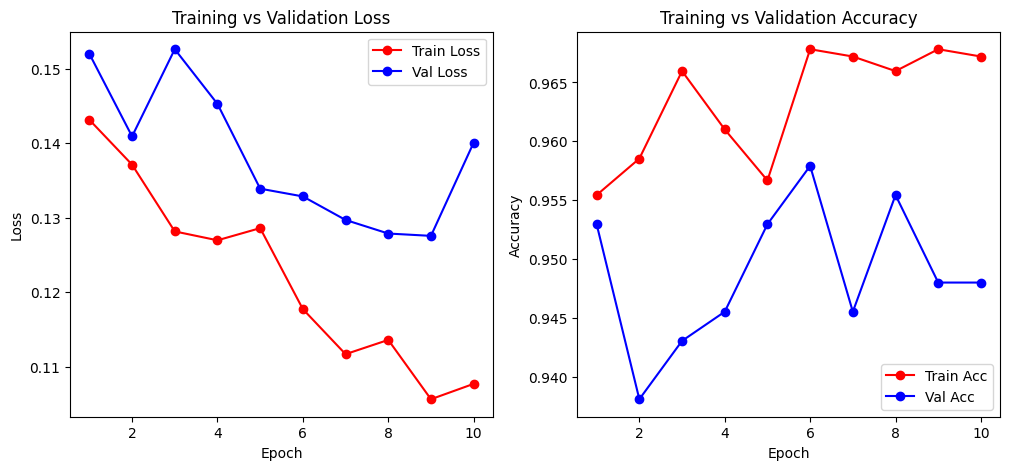

In [ ]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, 'r-o', label="Train Loss")
plt.plot(epochs_range, val_losses, 'b-o', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, 'r-o', label="Train Acc")
plt.plot(epochs_range, val_accs, 'b-o', label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


Accuracy of Bird                : 100.00%
Accuracy of Drone               : 100.00%
Accuracy of Long_Blade_Rotor    : 93.67%
Accuracy of RC_Plane            : 83.52%
Accuracy of Short_Blade_Rotor   : 98.61%


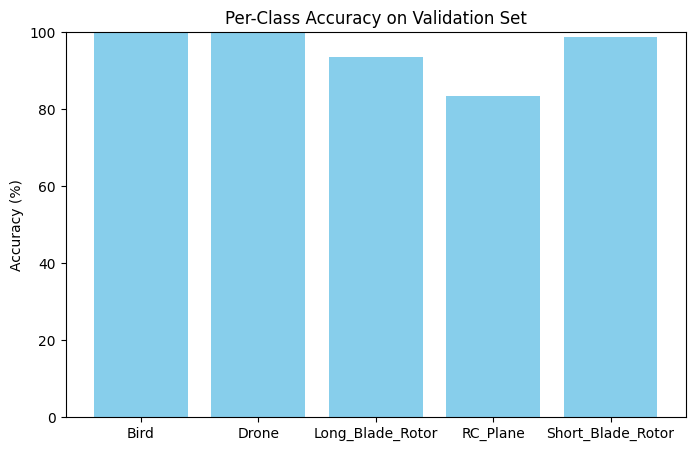

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# class names from dataset
class_names = val_dataset.dataset.classes  # e.g. ['Bird', 'Drone', 'Long_Blade_Rotor', 'RC_Plane', 'Short_Blade_Rotor']

# counters
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = preds[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

# compute per-class accuracy
class_acc = [100 * (c / t) if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# print results
for i, acc in enumerate(class_acc):
    print(f"Accuracy of {class_names[i]:20s}: {acc:.2f}%")

# plot bar chart
plt.figure(figsize=(8,5))
plt.bar(class_names, class_acc, color="skyblue")
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy on Validation Set")
plt.ylim(0, 100)
plt.show()
